<a href="https://www.pieriandata.com"><img src="../DATA/Logo.jpg"></a>
*Copyright by Pierian Data Inc.*

# Image Segementation and the Watershed Algorithm

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def display(img,cmap=None):
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)
    ax.imshow(img,cmap=cmap)

## Our Task: Draw Contours Around the Coins

-----------------

## Common Coin Example

## Naive Approach

Let's try to simply use a threshold and then use findContours.

### Example Image

In [4]:
sep_coins = cv2.imread('../DATA/pennies.jpg')

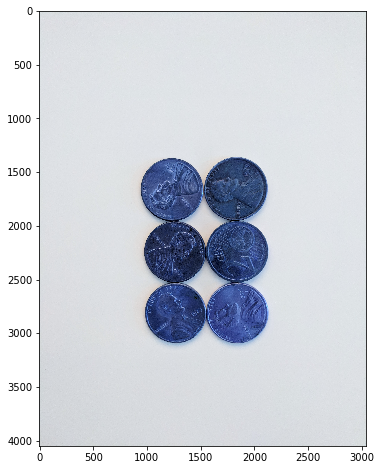

In [5]:
display(sep_coins)

### Apply Median Blurring

We have too much detail in this image, including light, the face edges on the coins, and too much detail in the background. Let's use Median Blur Filtering to blur the image a bit, which will be useful later on when we threshold.

In [6]:
sep_blur = cv2.medianBlur(sep_coins,25)

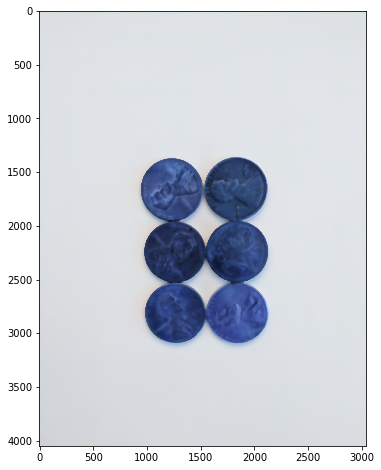

In [7]:
display(sep_blur)

In [8]:
gray_sep_coins = cv2.cvtColor(sep_blur,cv2.COLOR_BGR2GRAY)

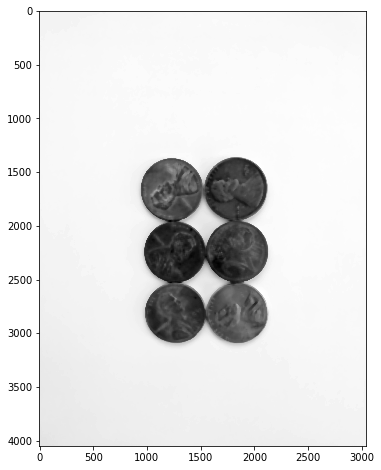

In [9]:
display(gray_sep_coins,cmap='gray')

## Binary Threshold

In [10]:
ret, sep_thresh = cv2.threshold(gray_sep_coins,160,255,cv2.THRESH_BINARY_INV)

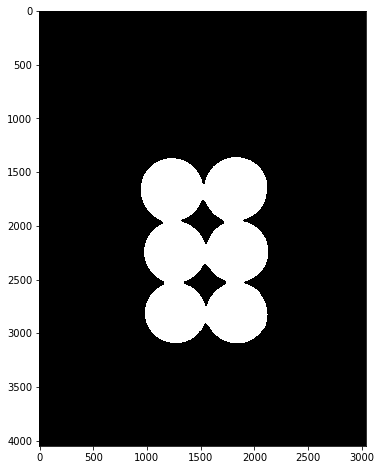

In [11]:
display(sep_thresh,cmap='gray')

## FindContours

In [12]:
image, contours, hierarchy = cv2.findContours(sep_thresh.copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

In [13]:
# For every entry in contours
for i in range(len(contours)):
    
    # last column in the array is -1 if an external contour (no contours inside of it)
    if hierarchy[0][i][3] == -1:
        
        # We can now draw the external contours from the list of contours
        cv2.drawContours(sep_coins, contours, i, (255, 0, 0), 10)

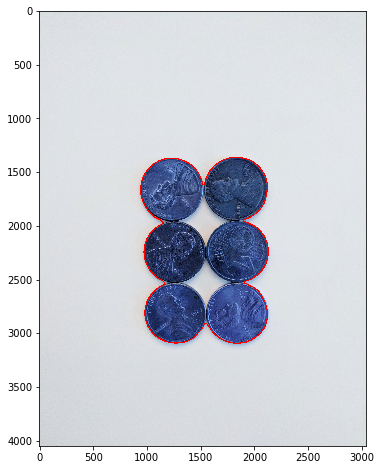

In [14]:
display(sep_coins)

# Watershed Algorithm

-----------

Let's now try the watershed algorithm apporach to draw contours around the pennies. Also make sure to watch the video to understand what the function calls are doing here.

## Using the WaterShed Algorithm

#### Step 1: Read Image

In [15]:
img = cv2.imread('../DATA/pennies.jpg')

#### Step 2: Apply Blur

In [16]:
img = cv2.medianBlur(img,35)

#### Step 3: Convert to Grayscale

In [17]:
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

#### Step 4: Apply Threshold (Inverse Binary with OTSU as well)

In [18]:
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

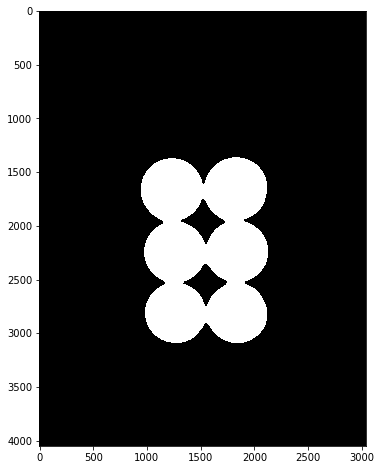

In [19]:
display(thresh,cmap='gray')

### Optional Step 5: Noise Removal

In [20]:
# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

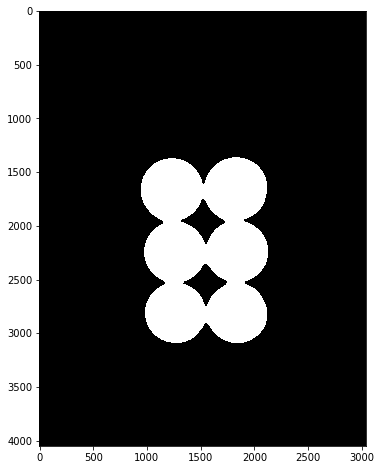

In [21]:
display(opening,cmap='gray')

#### Step 6: Grab Background that you are sure of

In [22]:
# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)

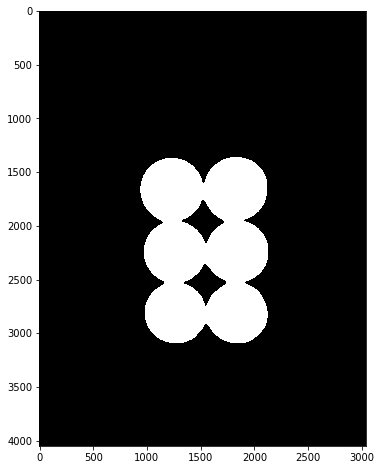

In [52]:
display(sure_bg,cmap='gray')

#### Step 7: Find Sure Foreground

In [53]:
# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

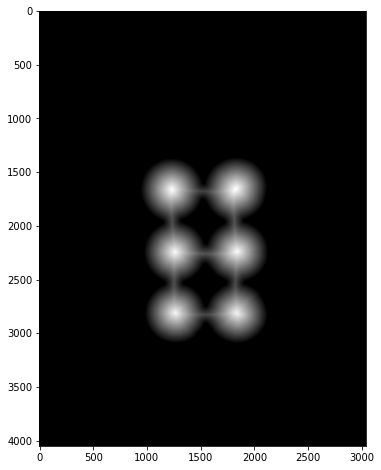

In [54]:
display(dist_transform,cmap='gray')

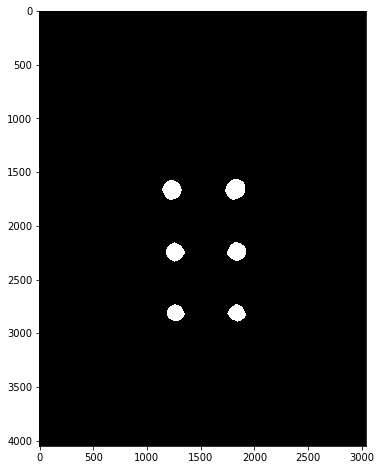

In [55]:
display(sure_fg,cmap='gray')

#### Step 8: Find Unknown Region

In [56]:
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)
unknown

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

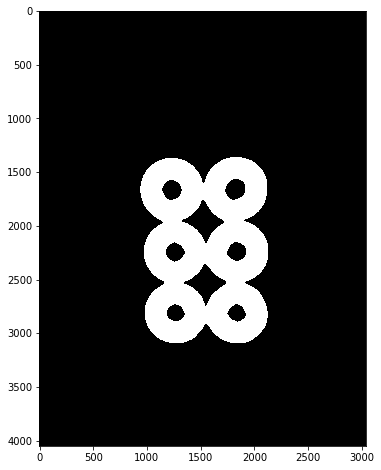

In [57]:
display(unknown,cmap='gray')

#### Step 9: Label Markers of Sure Foreground

In [103]:
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)
# Add one to all labels so that sure background is not 0, but 1
c=0
markers=markers+1
d ={}
for x in markers.ravel():
    if x!=1:
        if x not in d:
           c+=1
           d[x]=1
        else:
            d[x]+=1
        
c
d

{2: 27418, 3: 25048, 4: 23176, 5: 22169, 7: 19348, 6: 19586}

In [102]:
type(markers)

numpy.ndarray

# markers
display(markers,cmap='gray')

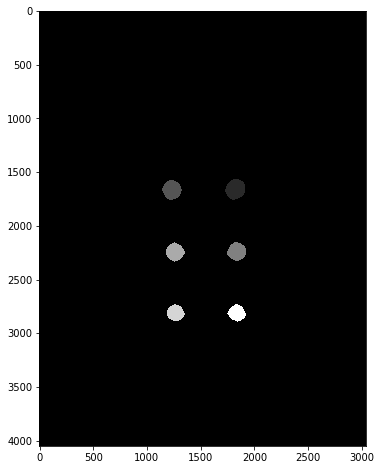

In [104]:

# Now, mark the region of unknown with zero
display(markers,cmap='gray')

In [105]:
markers[unknown==255] = 0

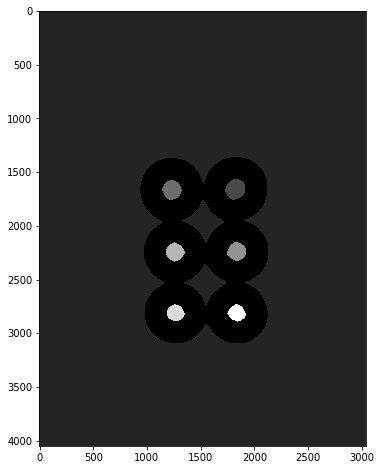

In [106]:
display(markers,cmap='gray')

#### Step 10: Apply Watershed Algorithm to find Markers

In [88]:
markers = cv2.watershed(img,markers)

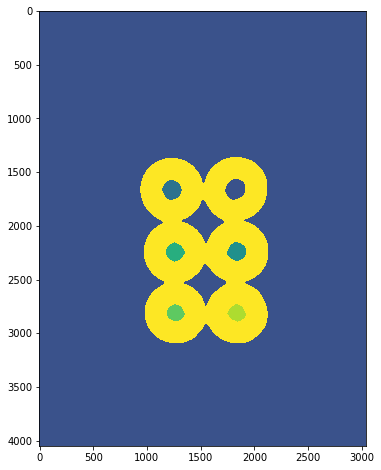

In [89]:
display(markers)

#### Step 11: Find Contours on Markers

In [90]:
image, contours, hierarchy = cv2.findContours(markers.copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

# For every entry in contours
for i in range(len(contours)):
    
    # last column in the array is -1 if an external contour (no contours inside of it)
    if hierarchy[0][i][3] == -1:
        
        # We can now draw the external contours from the list of contours
        cv2.drawContours(sep_coins, contours, i, (255, 0, 0), 10)

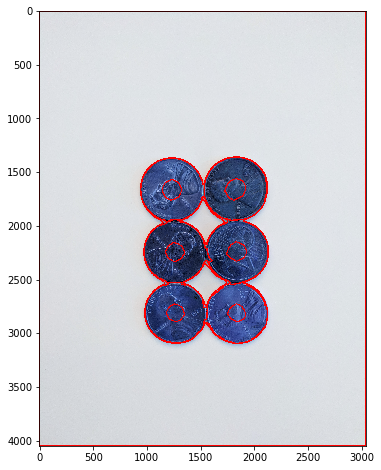

In [91]:
display(sep_coins)